In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://localhost:7077")\
    .appName("k-meaner")\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.6') \
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.6') \
    .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.12.99') \
    .config("spark.executor.memory", "512m") \
    .config("spark.executor.cores", "1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config('spark.hadoop.fs.s3a.access.key', '9818c1106da845c2a4fcfcab05674abd') \
    .config('spark.hadoop.fs.s3a.secret.key', '7918b4d8db2a45cc8d628c46315b62e6') \
    .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210') \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
    .config("com.amazonaws.sdk.disableCertChecking","true") \
    .getOrCreate()

sc = spark.sparkContext

23/07/07 20:26:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
from sklearn.datasets import fetch_kddcup99
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt

# Loading the `kddcup99` dataset

In [3]:
kdd = fetch_kddcup99(return_X_y=True)
n_samples = kdd[0].shape[0]

`kdd` is a tuple where the first element is an array of data points, while the second element is filled with the corresponding labels – i.e., the attack types.

In [4]:
kdd

(array([[0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        ...,
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0]], dtype=object),
 array([b'normal.', b'normal.', b'normal.', ..., b'normal.', b'normal.',
        b'normal.'], dtype=object))

In [5]:
labels = kdd[1]

Also, we save the number of unique labels; we will need this later when we choose the number of clusters for the `k-means`.

In [6]:
k = len(set(labels))

Let’s examine the distribution of attack types.

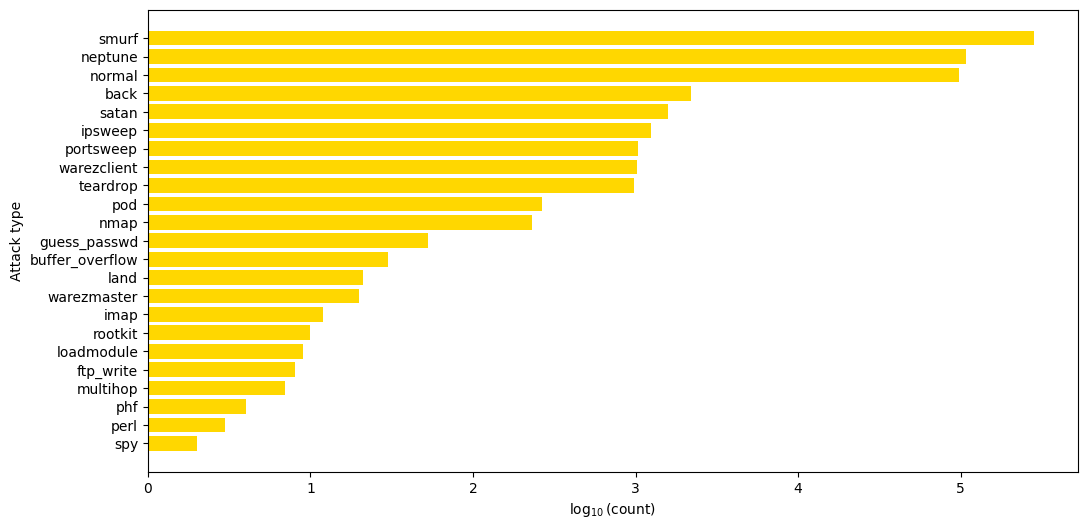

In [7]:
attacks, counts = np.unique(labels, return_counts=True)
ypos = np.arange(len(attacks))

attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()

# Pre-processing
We remove the “categorical” columns, and keep only the numerical ones. Then we rescale those to a [0, 1] range. Also, we remove two columns that happen to be all zeros. After all, this shouldn’t affect the clustering afterwards.

In [8]:
data_nocat = kdd[0][:, [0] + list(range(4, kdd[0].shape[1]))]
data_mins = np.amin(data_nocat, axis=0)
data_maxs = np.amax(data_nocat, axis=0)
nonzero_cols = (data_mins != data_maxs).astype(bool)

# rescale to 0-1 range
data = np.asarray(
    (data_nocat[:, nonzero_cols] - data_mins[nonzero_cols]) \
    / (data_maxs[nonzero_cols] - data_mins[nonzero_cols]),
    dtype=float
)

Now we load the objects into a Spark RDD.

In [9]:
kdd_rdd = sc.parallelize(
    [(0, {"features": data[i], "label": labels[i]}) for i in range(n_samples)],
    numSlices=32
)

# `k-means` implementation

## Initialization functions

In [10]:
def stupid_init(rdd, n_clusters):
    # we have to sample n_clusters *different* points
    ## we can't call .distinct() on the rdd because np.array is not hashable,
    ## so we first add a key with the raw data string of the array and then
    ## "unique-ize" with reduceByKey
    centroids = rdd \
        .map(lambda x: (x[1]["features"].tobytes(), x[1]["features"])) \
        .reduceByKey(lambda x, y: x) \
        .values() \
        .takeSample(withReplacement=False, num=n_clusters)

    # return tuples with cluster_id and centroid position
    return [(i, c) for i, c in enumerate(centroids)]

## Lloyd’s algorithm

In [11]:
def assign_to_cluster(sample, centroids):
    distances = np.sum((sample[1]["features"] - [c[1] for c in centroids])**2, axis=1)
    # get the cluster id from the closest centroid
    cluster_id = np.argmin(distances)

    return (centroids[cluster_id][0], sample[1])


def k_means(rdd, n_clusters, n_iters, init_func, *args, **kwargs):
    # get centroids from initalization function
    centroids = init_func(rdd, n_clusters, *args, **kwargs)

    for i in range(n_iters):        
        # find the nearest centroid to each sample
        # and cache the dataset in memory for faster access
        rdd_cached = rdd \
            .map(lambda x: assign_to_cluster(x, centroids)) \
            .persist()
        
        # update the centroids by averaging the points inside
        centroids = rdd_cached \
            .mapValues(lambda x: (x["features"], 1)) \
            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
            .mapValues(lambda x: x[0] / x[1]) \
            .collect()

        # clear the cache
        rdd_cached.unpersist()
        
    return centroids


In [12]:
%%time
k_means(kdd_rdd, k, 10, stupid_init)

23/07/07 20:27:20 WARN TaskSetManager: Stage 0 contains a task of very large size (5151 KiB). The maximum recommended task size is 1000 KiB.
23/07/07 20:27:29 WARN TaskSetManager: Stage 4 contains a task of very large size (5151 KiB). The maximum recommended task size is 1000 KiB.
23/07/07 20:27:37 WARN TaskSetManager: Stage 6 contains a task of very large size (5151 KiB). The maximum recommended task size is 1000 KiB.
23/07/07 20:27:45 WARN TaskSetManager: Stage 8 contains a task of very large size (5151 KiB). The maximum recommended task size is 1000 KiB.
23/07/07 20:27:54 WARN TaskSetManager: Stage 10 contains a task of very large size (5151 KiB). The maximum recommended task size is 1000 KiB.
23/07/07 20:28:02 WARN TaskSetManager: Stage 12 contains a task of very large size (5151 KiB). The maximum recommended task size is 1000 KiB.
23/07/07 20:28:09 WARN TaskSetManager: Stage 14 contains a task of very large size (5151 KiB). The maximum recommended task size is 1000 KiB.
23/07/07 2

CPU times: user 379 ms, sys: 176 ms, total: 555 ms
Wall time: 1min 29s


[(0,
  array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 5.30073368e-01, 2.82185410e-02, 1.00000000e+00,
         9.99935057e-01, 0.00000000e+00, 7.49344324e-06, 5.33441572e-02,
         5.64331210e-02, 8.61745972e-05, 9.99654877e-01, 5.56325307e-02,
         5.54631364e-02, 6.34503143e-02, 1.33216769e-05, 0.00000000e+00,
         9.99963782e-01, 1.00000000e+00, 2.08151201e-06, 0.00000000e+00])),
 (1,
  array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.39452756e-0

In [13]:
sc.stop()
spark.stop()